In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from spacy import displacy
from IPython.display import display, HTML
from collections import Counter
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

c:\Users\Lenovo\OneDrive\Pictures\Tugas A - PBA\ProjectA_TJ-Transjakarta_PBA2025-gasal\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
# --- 1. Konfigurasi dan Pemodelan NER (IndoBERT) ---
MODEL_NAME = "cahya/bert-base-indonesian-NER"

# Inisialisasi Tokenizer dan Model IndoBERT
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
except Exception as e:
    print(f"Error memuat model IndoBERT: {e}")
    print("Pastikan Anda sudah menginstal: pip install transformers datasets torch")
    exit()

# Membuat NER Pipeline (TANPA truncation di inisialisasi)
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")
print(f"Model NER IndoBERT '{MODEL_NAME}' berhasil dimuat.")

Some weights of the model checkpoint at cahya/bert-base-indonesian-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


Model NER IndoBERT 'cahya/bert-base-indonesian-NER' berhasil dimuat.


In [21]:
# --- 2. Fungsi Utama untuk Menjalankan NER ---

def run_ner(text):
    """Mendeteksi entitas bernama dari teks menggunakan IndoBERT (dengan truncation)."""
    if not isinstance(text, str) or pd.isna(text):
        return []
    
    try:
        # Panggil pipeline DENGAN truncation=True
        entities = ner_pipeline(text) 
        
        # Format hasil untuk penyimpanan: (Entitas, Label, Score, Start, End)
        formatted_entities = []
        for e in entities:
            formatted_entities.append({
                'entity': e['word'],
                'label': e['entity_group'],
                'start': e['start'],
                'end': e['end']
            })
        return formatted_entities
    except Exception as e:
        print(f"Warning: Error saat memproses NER pada teks: {e}") 
        return []

In [34]:
def merge_adjacent_entities(entities):
    """Menggabungkan entitas yang berdekatan dengan label yang sama (e.g., 'Budi PER Utomo PER')."""
    if not entities:
        return []
    
    entities = sorted(entities, key=lambda e: e['start'])
    merged = []
    current_entity = dict(entities[0])
    
    for next_entity in entities[1:]:
        next_entity = dict(next_entity)
        
        if next_entity['start'] <= current_entity['end'] + 1 and next_entity['label'] == current_entity['label']:
            current_entity['entity'] += " " + next_entity['entity']
            current_entity['end'] = next_entity['end']
        else:
            merged.append(current_entity)
            current_entity = next_entity
            
    merged.append(current_entity)
    return merged

# Daftar label yang RELEVAN sesuai kesepakatan
RELEVANT_LABELS = {
    'ORG', 'LOC', 'PER', 'GPE', 'FAC',  # Relevan Tinggi
    'DAT', 'TIM', 'EVT', 'NOR', 'LAW', 'PRD'  # Relevan Sedang
}

def filter_relevance_and_clean_entities(entities):
    """
    Memfilter entitas hanya yang relevan, mengoreksi PRD, dan menghapus artefak WordPiece (##).
    Menggantikan filter_and_correct_prd sebelumnya.
    """
    corrected = []
    
    # Kata-kata yang TIDAK boleh menjadi PRD
    EXCLUDE_PRD = {'bus', 'truk', 'rem', 'rem blong', 'video', 'gambas', 'tj', 'lrt', 'mrt', 'transjakarta'}
    NOISE_ENTITIES = {'SCROLL', 'CONTENT', 'TENT', 'EVT', 'TO', 'CONTIN'}
    
    for e in entities:
        entity_text_lower = e['entity'].lower().strip()
        label = e['label']
        
        # 1. Hapus Noise Sisa Scraping
        if e['entity'].upper().strip() in NOISE_ENTITIES:
            continue
            
        # 2. Filtering Relevansi
        if label not in RELEVANT_LABELS:
            continue # Hapus label non-relevan (CRD, QTY, ORD, MON, REG)

        # 3. Koreksi PRD
        if label == 'PRD':
            if entity_text_lower in EXCLUDE_PRD:
                if entity_text_lower in ('mrt', 'lrt', 'transjakarta', 'tj'):
                    e['label'] = 'ORG' # Re-labeling
                else:
                    continue # Hapus kata umum
        
        # 4. Pembersihan Artefak WordPiece (##)
        cleaned_text = e['entity'].replace('##', '').strip()
        
        # 5. Hapus Noise Karakter Tunggal/Sangat Pendek Setelah Cleaning
        if len(cleaned_text) <= 1:
            continue
            
        e['entity'] = cleaned_text
        
        corrected.append(e)
        
    return corrected

In [35]:
# --- 4. Membaca Data dan Menerapkan NER ---
input_filepath = '../Data/hasil_final_analisis_transjakarta.csv' 

try:
    df = pd.read_csv(input_filepath)
    # Ubah sentimen menjadi huruf kecil untuk konsistensi pemfilteran (sesuai kebutuhan Anda sebelumnya)
    df['Sentimen'] = df['Sentimen'].astype(str).str.lower().str.strip()
    print(f"\nFile '{input_filepath}' berhasil dibaca. Jumlah data: {len(df)} baris.")
except FileNotFoundError:
    print(f"Error: File '{input_filepath}' tidak ditemukan.")
    exit()

print("Memulai proses Named Entity Recognition (NER) pada Teks_Lengkap...")
# Penerapan NER Mentah
df['Entitas_NER_Raw'] = df['Teks_Bersih'].apply(run_ner)
print("NER Mentah Selesai.")


File '../Data/hasil_final_analisis_transjakarta.csv' berhasil dibaca. Jumlah data: 150 baris.
Memulai proses Named Entity Recognition (NER) pada Teks_Lengkap...
NER Mentah Selesai.


In [36]:
# A. Gabungkan entitas (Fusion)
df['Entitas_NER_Fused'] = df['Entitas_NER_Raw'].apply(merge_adjacent_entities)
print("Post-Processing: Entitas berhasil digabungkan (Fused).")

# B. Filter dan koreksi PRD
df['Entitas_NER_Final'] = df['Entitas_NER_Fused'].apply(filter_and_correct_prd)
print("Post-Processing: Entitas PRD umum berhasil difilter/dikoreksi.")

Post-Processing: Entitas berhasil digabungkan (Fused).
Post-Processing: Entitas PRD umum berhasil difilter/dikoreksi.


In [37]:
# --- 6. Perhitungan Total Frekuensi Entity Final ---

all_final_labels = []
# Menggunakan kolom yang sudah difilter dan dibersihkan
for index, row in df.iterrows():
    # Loop melalui kolom yang SUDAH DIBERSIHKAN
    final_entities = row['Entitas_NER_Final'] if isinstance(row['Entitas_NER_Final'], list) else ast.literal_eval(row['Entitas_NER_Final'])
    for entity in final_entities:
        label = entity.get('label')
        if label:
            all_final_labels.append(label)

label_counts_final = Counter(all_final_labels)
df_counts_final = pd.DataFrame(label_counts_final.items(), columns=['Entity_Label', 'Count'])
df_counts_final = df_counts_final.sort_values(by='Count', ascending=False).reset_index(drop=True)


print("\n--- Frekuensi Total Setiap Entity (Setelah Filtrasi Relevansi & Cleaning) ---")
print(df_counts_final)


--- Frekuensi Total Setiap Entity (Setelah Filtrasi Relevansi & Cleaning) ---
   Entity_Label  Count
0           ORG   1986
1           LOC   1111
2           NOR    935
3           PRD    895
4           EVT    812
5           PER    525
6           GPE    344
7           DAT    229
8           FAC     79
9           MON     47
10          LAW     28
11          CRD     24
12          QTY      4
13          REG      4
14          TIM      3
15          ORD      3
16          PRC      2



✅ Visualisasi frekuensi entitas disimpan sebagai: ../Data/visualisasi_ner_frekuensi_final.png


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_27028\3610843477.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Entity_Label', data=df_top_10, palette='viridis')


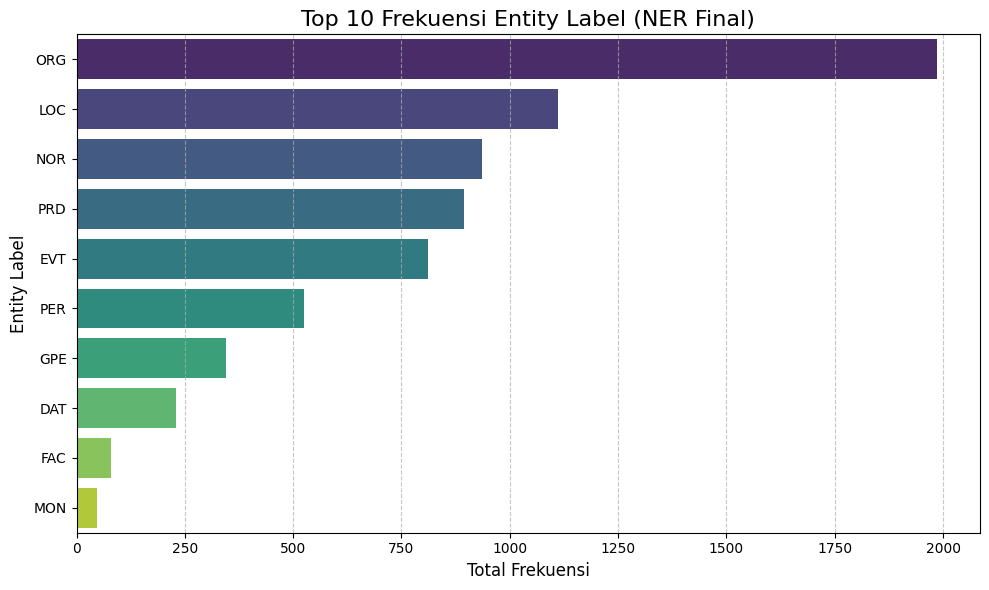

In [38]:
# --- 7. Visualisasi Frekuensi (Bar Chart Top 10) ---

image_filename = '../Data/visualisasi_ner_frekuensi_final.png'

plt.figure(figsize=(10, 6))
df_top_10 = df_counts_final.head(10)

sns.barplot(x='Count', y='Entity_Label', data=df_top_10, palette='viridis')
plt.title('Top 10 Frekuensi Entity Label (NER Final)', fontsize=16)
plt.xlabel('Total Frekuensi', fontsize=12)
plt.ylabel('Entity Label', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(image_filename)
print(f"\n✅ Visualisasi frekuensi entitas disimpan sebagai: {image_filename}")

In [40]:
import pandas as pd
from collections import defaultdict, Counter
from IPython.display import display
import numpy as np 
import ast

def safe_convert_final_entity(x):
    """Mencoba mengkonversi string JSON (jika ada) atau mengembalikan list jika sudah list."""
    if isinstance(x, list):
        return x
    if pd.isna(x) or not isinstance(x, str) or x.strip() in ('[]', ''):
        return []
    try:
        return ast.literal_eval(x)
    except:
        return []
    

In [41]:
def clean_subword_artifacts(entities):
    """Menghapus atau membersihkan penanda ## dari teks entitas."""
    cleaned_entities = []
    for e in entities:
        # Hapus semua kemunculan '##'
        cleaned_text = e['entity'].replace('##', '')
        
        # Hapus entitas jika setelah dibersihkan menjadi kosong atau terlalu pendek
        if len(cleaned_text.strip()) > 1:
            e['entity'] = cleaned_text.strip()
            cleaned_entities.append(e)
            
    return cleaned_entities

df['Entitas_NER_Cleaned'] = df['Entitas_NER_Final'].apply(clean_subword_artifacts)

In [42]:
try:
    df['Entitas_NER_List'] = df['Entitas_NER_Cleaned'].apply(safe_convert_final_entity)
except KeyError:
    print("Error: Pastikan DataFrame 'df' sudah dimuat dan memiliki kolom 'Entitas_NER_Final' dan 'Sentimen'.")
    exit()

In [45]:
def generate_entity_summary_df(data_subset, sentiment_label):
    """Menghitung Top 20 entitas per label untuk subset data tertentu."""
    entities_by_label = defaultdict(lambda: defaultdict(int)) 

    for index, row in data_subset.iterrows():
        # Menggunakan Entitas_NER_List yang sudah difilter dan dibersihkan
        for entity in row['Entitas_NER_List']: 
            label = entity.get('label')
            word = entity.get('entity')
            
            if label and word:
                entities_by_label[label][word.lower().strip()] += 1

    output_rows = []
    # Urutkan label secara descending berdasarkan total kemunculan
    sorted_labels = sorted(entities_by_label.keys(), 
                           key=lambda k: sum(entities_by_label[k].values()), 
                           reverse=True)

    for label in sorted_labels:
        # Ambil 20 kata teratas untuk setiap label
        top_words_with_freq = Counter(entities_by_label[label]).most_common(20)
        
        # Format kata-kata menjadi string
        words_formatted = [f"{word} ({freq})" for word, freq in top_words_with_freq]
        word_list_str = "; ".join(words_formatted)
        
        output_rows.append({
            'Entity Label': label,
            f'Top 20 Kata ({sentiment_label.title()}) (Frekuensi)': word_list_str
        })

    return pd.DataFrame(output_rows)

# --- Proses Analisis per Sentimen, Tampilkan, dan Simpan ke CSV ---

# Gunakan huruf kecil karena df['Sentimen'] sudah diubah ke huruf kecil
sentiments = ['positif', 'netral', 'negatif'] 
base_filepath = '../Data/entity_summary_'

print("=================================================================")
print("Memulai analisis Top 20 Entitas per Sentimen (Disimpan ke CSV & Ditampilkan)")
print("=================================================================")

# Setting tampilan Pandas agar string tidak terpotong saat ditampilkan
with pd.option_context('display.max_colwidth', None):
    for sentiment in sentiments:
        print(f"\n--- ANALISIS SENTIMEN: {sentiment.upper()} ---")
        
        # 1. Filter DataFrame berdasarkan Sentimen (sudah diubah ke lower di awal)
        df_subset = df[df['Sentimen'] == sentiment].copy()
        
        if df_subset.empty:
            print(f"⚠️ Sentimen '{sentiment.upper()}': Data kosong, melompati. Pastikan nilai di kolom 'Sentimen' adalah '{sentiment}'.")
            continue
            
        # 2. Menghitung ringkasan entitas untuk subset ini
        df_summary = generate_entity_summary_df(df_subset, sentiment)
        
        # 3. Menampilkan tabel ringkasan
        display(df_summary)
        
        # 4. Menyimpan ringkasan ke file CSV
        output_filepath_csv = f"{base_filepath}{sentiment.lower()}_transjakarta.csv"
        
        df_summary.to_csv(output_filepath_csv, index=False, encoding='utf-8')
        
        print(f"✅ Tabel ringkasan sentimen '{sentiment.upper()}' berhasil disimpan di: {output_filepath_csv}")
        
print("\n=================================================================")
print("✅ Semua ringkasan entitas per sentimen berhasil diproses dan disimpan.")

Memulai analisis Top 20 Entitas per Sentimen (Disimpan ke CSV & Ditampilkan)

--- ANALISIS SENTIMEN: POSITIF ---


,Entity Label,Top 20 Kata (Positif) (Frekuensi)
0,ORG,transjakarta (247); jakarta (27); tempo (15); detik (14); pt transportasi jakarta transjakarta (10); indonesia (8); ono (8); dki (8); pt (7); jak (7); umum (7); bank dki (6); direktur (6); wahyu (6); moda (6); tis (6); listrik (5); fizon (5); bank (5); pusat (5)
1,EVT,transjakarta (13); jakarta (7); timur (6); agustus (6); umum (5); ue (5); moda raya (5); bs (5); ji (5); de (4); oll (4); april (4); raya (4); gratis (4); kampanye (4); halte (4); warna (4); transportasi (3); ancol (3); utama (3)
2,LOC,halte (28); transjakarta (9); stasiun (8); blok mancol (6); blok (6); vi (6); taman (6); jalan (4); jembatan (4); moda (4); rp (4); balai kota (3); koridor (3); cempaka putih (3); trans (3); kawasan (3); bus (3); rev (3); metro (3); stadion (3)
3,PRD,bus listrik (17); ai (12); halte (11); bus transjakarta (11); rp (8); transportasi (8); ay (8); dki (7); kendaraan (7); krl (6); agent (6); jakarta (5); trans (5); digital (5); pesawat (5); kai (5); transjakarta moda raya terpadu lintas rel terpadu jakarta (4); kartu jakcard combo (4); teknologi (4); terpadu (4)
4,NOR,pemerintah (27); gubernur (11); tni (11); transjakarta (8); pemprov dki jakarta (7); presiden (6); gubernur dki jakarta (5); gubernur jakarta (5); pemprov dki (4); polisi (4); kepala departemen humas csr transjakarta (4); balai (4); bs (4); polda (4); trans (4); depok (4); kepala (3); kepolisian (3); pem (3); dewan (3)
5,PER,pram (19); ayu wardhani (15); pram ono (13); ayu (12); dod (9); pramono anung (6); taufan (5); wel (4); prabowo (4); raditya maulana rusdi (3); pramono (3); sura (3); rano karno (2); syaf (2); sigit (2); yuza (2); syafrin lip (2); pramono anu (2); fadly hasan (2); dt (2)
6,GPE,jakarta (117); depok (8); indonesia (7); dki jakarta (6); jawa (4); makassar (4); kota (4); kota depok (4); bekasi (2); jakarta selatan (2); jakarta timur (2); jakarta jawa (2); jakarta jakarta (1); bali (1); dki (1); provinsi (1); jawa barat banten (1); jakarta jawa barat (1); banten (1); makassar sulawesi (1)
7,DAT,sabtu (16); jumat (10); agustus (9); kamis (9); rabu (9); senin (9); april (9); senin september (4); september september (3); selasa (3); september (2); juni (2); minggu (2); juta (2); ad oktober (2); agustus september (2); senin april (2); ahad april (2); desember (2); januari (2)
8,FAC,transjakarta (4); pelabuhan (3); priok (2); bandara (2); halte (2); stasiun (2); istora mandiri (2); moda (2); stasiun moda raya terpadu bundaran hi jakarta (2); pelabuhan tanjung priok terminal tanjung priok (2); pelabuhan tanjung priok (2); penumpang (1); tosari jakarta (1); universitas (1); pulo gadung (1); krl stasiun (1); bus (1); jembatan halte manggarai (1); terminal keberangkatan bus transjakarta (1); ora mandiri (1)
9,MON,rp (20); rp agustus (2); rp ribu (1); rp terjangkau rp rp (1); rp scr (1); subsidi (1); rp triliun (1); rp triliun rp triliun (1); rp rp (1); rp sebulan (1); rp rd (1); rp tempo (1); rp miliar (1)


✅ Tabel ringkasan sentimen 'POSITIF' berhasil disimpan di: ../Data/entity_summary_positif_transjakarta.csv

--- ANALISIS SENTIMEN: NETRAL ---


,Entity Label,Top 20 Kata (Netral) (Frekuensi)
0,ORG,transjakarta (34); tempo (4); normal (4); detik (3); wib (3); rin (2); pt (2); direktur (2); pt transportasi jakarta transjakarta (2); fizon (2); ld (2); liputancom jakarta (2); koridor (2); jak jak jak jak jak jak jak jak jak jak jak jak jak jak jak jak (2); pt transjakarta koridor (1); motor (1); provinsi (1); raya (1); rt (1); bar (1)
1,LOC,dukuh (3); blok alam sutera terminal blok jakarta (3); transjabodetabek (2); kantor (2); halte (2); cb (2); ciledug (2); melayu (2); titik (1); gerbang tol semanggi mt haryono signature park rs dharma (1); halte gerbang pemuda exit (1); halte pancoran (1); separ (1); rs (1); et (1); terminal rawa buaya bus (1); pool terminal rawa buaya cengkareng (1); rawa (1); terminal blok jakarta selatan (1); daerah penyangga jakarta transjabodetab (1)
2,PRD,bus transjakarta (7); qu (5); jak (5); mobil (4); bus halte (3); dki (3); nbs (3); bus hangus (2); trans (2); triliun (2); at (2); bus transjakarta koridor (1); rambu (1); ator (1); km km (1); truk sepeda (1); rangkarang (1); rangka (1); kursi plastik bus rangka logam (1); taksi (1)
3,NOR,pemerintah (7); transjakarta (5); ator (4); polisi (3); dishub (2); uk (2); de (2); kepala dinas perhubungan dki jakarta (2); dpr (2); pemprov dki (1); pemprov dki jakarta (1); kepala dishub dki jakarta (1); is dpr ri (1); itas (1); lintas (1); com (1); separator (1); kut (1); gubernur jakartapramono (1); pemprov dki daerah (1)
4,PER,taufan reng (4); pram (3); rano karno (3); ayu wardhani (3); ayu (3); syafrin lip (2); affan kurniawan (2); juni tempomagangahmad naufal oktavian (2); juni (2); ayu ayu (2); syafrin (1); syaf (1); syafrin liputo (1); pramono (1); kamis pramono (1); yu (1); vi (1); pramono anung (1); wel (1); welfizon yuza (1)
5,GPE,jakarta (27); bekasi (4); kota tangerang banten (4); jakarta barat (1); bogor (1); jakarta pusat (1); amerika (1); dki (1); semarang (1); tegal (1); tangerang (1); kota jakarta (1)
6,EVT,bus (2); lelang (2); bs (2); libur lebaran (2); pool terminal rawa buaya cengkareng (1); barat (1); terminal (1); buaya (1); rin (1); transjakarta (1); dki (1); busbus (1); lang (1); syafrin (1); ran (1); road (1); rw (1); ambi kecamatan cengkareng jak (1); wib (1); wisata (1)
7,DAT,juni (6); jumat (1); selasa (1); mei (1); rabu (1); kamis (1); kamis oktober (1); senin (1); sabtu agustus (1); senin agustus (1); minggu (1); minggu juni (1)
8,MON,rp (11); rp pram (1); enam (1)
9,LAW,ld (2); qu (1); apbd (1); pay (1); rin (1); apbn (1); surat keputusan kepala (1); jakarta nomor tahun moda raya terpadu jam (1)


✅ Tabel ringkasan sentimen 'NETRAL' berhasil disimpan di: ../Data/entity_summary_netral_transjakarta.csv

--- ANALISIS SENTIMEN: NEGATIF ---


,Entity Label,Top 20 Kata (Negatif) (Frekuensi)
0,ORG,transjakarta (171); ojol (11); jakarta (7); selatan (6); dki (6); tempo (6); pt transjakarta (5); lintas (5); persija (5); pt (5); ng (4); kt (4); motor (4); liputancom jakarta (4); tis (4); unit (4); detik (3); indonesia (3); ji (3); ol (3)
1,NOR,transjakarta (18); polisi (17); kepolisian (11); polda metro jaya (8); gubernur (7); pemerintah (7); dpr (7); polda (6); kn (5); brimob (5); polda metro (5); kepala departemen (5); an (5); jakarta (5); qu (5); komisaris (5); transportasi (4); ol (4); pemerintah provinsi dki jakarta (4); gubernur jakarta (4)
2,LOC,halte (27); transjakarta (9); cawang (4); ancol (4); mikrotrans (4); tup (4); stasiun (4); jaya (3); halte transjakarta (3); trans (3); puri beta (3); halte gerbang (3); rumah (3); lapangan (3); jalan gatsu (2); halte tanjung duren (2); jalan saharjo (2); jalan cideng timur (2); jalan (2); prov (2)
3,PER,pramono (14); pram (11); ayu (9); johan budi (9); ayu wardhani (7); oj (6); affa (5); saf (5); johan (5); pramono anung (4); sima (4); jh (4); tamar (4); akbp ojo ruslani (3); anwar (3); jumat (3); aif (3); ai (3); rangga (3); ld (3)
4,PRD,bus transjakarta (22); mobil (14); motor (12); sepeda motor (7); bus listrik (5); instagram (4); trans (3); tb (3); kompas (3); ban bus transjakarta (3); rp (3); persen (3); bustrans (2); budi (2); jakarta (2); ojek (2); cctv (2); sistem angkutan umum bingkai transportasi makro (2); mog (2); ang (2)
5,GPE,jakarta (83); dki (4); jakarta barat (4); jakarta selatan (3); jakarta pusat (3); jak (3); cile (2); ancol (2); kota (2); setia (1); tarakan (1); plumpang (1); ja jakarta utara jakut (1); maluku utara (1); tanjung (1); banten (1); jakarta timur jakarta utara (1); teb (1); kota jakarta (1); dki jakarta (1)
6,DAT,jumat (13); september (9); sabtu (6); agustus (6); kamis (4); senin (4); jumat agustus (4); senin september (4); selasa (3); maret (3); sabtu agustus (3); januari (2); minggu (2); beroperasi februari (1); rabu (1); januariseptember (1); ahad september (1); selasa september (1); senin agustus (1); kamis agustus (1)
7,EVT,bs (7); demonstrasi (6); demonstrasi agustus (4); agustus (4); jakarta (3); lo (2); bsp (2); qu (2); halte (2); fit (1); work (1); de (1); oll to continue with (1); sh (1); tle (1); an (1); maaf (1); beroperasi (1); bat (1); hitam (1)
8,FAC,jembatan (3); priok (2); halte transjakarta (2); transjakarta (2); halte (2); rsud tarakan (1); rsud (1); tanjung (1); lin (1); apa (1); jembatan puri beta (1); tebet (1); tebet jakarta selatan (1); teb (1); halte transjakarta jagajakarta (1); tol ruas (1); stasiun cakung (1); palmerah (1)
9,CRD,tujuh (7); enam (6); delapan (1); ketiga (1)


✅ Tabel ringkasan sentimen 'NEGATIF' berhasil disimpan di: ../Data/entity_summary_negatif_transjakarta.csv

✅ Semua ringkasan entitas per sentimen berhasil diproses dan disimpan.


In [44]:
# --- 8. Visualisasi Bersih (Cuplikan 5 Baris Pertama) ---

def visualize_clean_ner(text, entities_raw):
    """Fungsi displacy yang hanya menampilkan label yang relevan."""
    RELEVANT_LABELS = ["PER", "GPE", "LOC", "ORG", "EVT", "TME", "DAT"]
    
    ents = []
    for ent in entities_raw:
        if ent['label'] in RELEVANT_LABELS:
            ents.append({
                'start': ent['start'],
                'end': ent['end'],
                'label': ent['label']
            })
    
    doc_data = {'text': text, 'ents': ents}
    
    options = {
        "ents": RELEVANT_LABELS,
        "colors": {
            "PER": "#AA96DA", "GPE": "#82CD47", "LOC": "#FF90BB",
            "ORG": "#F0E442", "EVT": "#009E73", "TME": "#5D9C59", "DAT": "#0072B2"
        }
    }
    
    # Rendering displacy (hanya berfungsi di lingkungan notebook/Colab)
    html = displacy.render(doc_data, style="ent", manual=True, options=options, jupyter=False)
    return html

print("\n--- CUPLIKAN VISUALISASI NER BERSIH (5 BARIS PERTAMA) ---")
for index, row in df.head(5).iterrows():
    # Gunakan kolom Entitas_NER_Final
    html_output = visualize_clean_ner(row['Teks_Lengkap'], row['Entitas_NER_Final'])
    display(HTML(html_output))
    print("-" * 50)

# --- 9. Menyimpan Data Final NER ---
output_filepath_final_ner = '../Data/hasil_ner_final_transjakarta.csv'
# Simpan DataFrame dengan kolom entitas mentah, fused, dan final
df.to_csv(output_filepath_final_ner, index=False, encoding='utf-8')
print(f"\n✅ Data NER Final (bersih dan terfusi) disimpan di: {output_filepath_final_ner}")


--- CUPLIKAN VISUALISASI NER BERSIH (5 BARIS PERTAMA) ---


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------


--------------------------------------------------

✅ Data NER Final (bersih dan terfusi) disimpan di: ../Data/hasil_ner_final_transjakarta.csv
